<a href="https://colab.research.google.com/github/AdamW1002/Fall21Research/blob/main/analysis_of_actvations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [100]:
import torch #imports
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [101]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [102]:
batch_size = 128
n_iters = 2500
num_epochs = 2
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [103]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("on gpu")
else:  
  dev = "cpu"
class LoggerLayer(nn.Module):
      def __init__(self, other_layer : nn.Module, log : list):
        super(LoggerLayer, self).__init__()
        self.log = log 
        self.layer = other_layer
        self.logging = False#no logging during training

      def forward(self, x):
        y =   self.layer(x)

        if self.logging:  
          self.log.append(y)
        return y
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()


       
        # Linear function
        self.fc1 = nn.Linear(input_dim, 256) 
        self.fc2 = nn.Linear(256, 32) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc3 = nn.Linear(32, output_dim)  

        #loggers
        self.log_relu = nn.ReLU()
        self.logger1 = LoggerLayer(self.log_relu,[])
        self.logger2 = LoggerLayer(self.log_relu, [])
        self.logger3 = LoggerLayer(self.fc3, [])

        

      

    def forward(self, x):
        
        out = self.fc1(x)

        
        out = self.logger1(out)
        
        out = self.fc2(out)
        out = self.logger2(out)

        
        out = self.logger3(out)
       
        return out

In [104]:
input_dim = 28*28
hidden_dim = 128
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
print(model.logger1.log)

[]


In [105]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [106]:
iter = 0
print(model)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                #print(predicted)
                
                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            #print(model.logger1.log[0].shape)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (log_relu): ReLU()
  (logger1): LoggerLayer(
    (layer): ReLU()
  )
  (logger2): LoggerLayer(
    (layer): ReLU()
  )
  (logger3): LoggerLayer(
    (layer): Linear(in_features=32, out_features=10, bias=True)
  )
)
Iteration: 100. Loss: 0.87482750415802. Accuracy: 76.62999725341797
Iteration: 200. Loss: 0.3806324601173401. Accuracy: 87.41999816894531
Iteration: 300. Loss: 0.47821858525276184. Accuracy: 89.20999908447266
Iteration: 400. Loss: 0.34766215085983276. Accuracy: 90.56999969482422
Iteration: 500. Loss: 0.3251226246356964. Accuracy: 91.4800033569336
Iteration: 600. Loss: 0.4002595841884613. Accuracy: 91.72000122070312
Iteration: 700. Loss: 0.29407429695129395. Accuracy: 92.37999725341797
Iteration: 800. Loss: 0.22621622681617737. Accuracy: 93.4899978637

In [107]:
def analyze_activations(logger : LoggerLayer, network : nn.Module, loader) -> None:
  data_points = []
  logger.logging = True
  count = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader): #look at image and labels
      for image, label in zip(images, labels): 
    
        outputs = model(torch.flatten(image))
        
        activation = logger.log[count]
        data_points.append( (activation.data.detach().cpu().numpy(), int(label)))
        count = count + 1
  high_dim_vectors, labels = list(zip(*data_points)) #make vectors into numpy array
  data_array = np.stack(high_dim_vectors, axis = 0)

  for i in range(data_array.shape[0]): #make array activations
    for j in range(data_array.shape[1]):
      if data_array[i][j] > 0 and type(logger.layer) is nn.ReLU:
        data_array[i][j] = 1  
  print(data_array[0])
  pca = PCA(n_components=2)
  low_dim_vectors = pca.fit_transform(high_dim_vectors)
  print(low_dim_vectors.shape)
  pca3d = PCA(n_components = 3)
  vectors3d = pca3d.fit_transform(high_dim_vectors)        
  print("explained variances: {}".format(pca3d.explained_variance_ratio_))
  for i in range(int(low_dim_vectors.shape[0]/20)):# go thru and plot all points
    label = labels[i]
    x,y = low_dim_vectors[i]
    color = ""
    if label == 0:
      color = "black"
    elif label == 1:
      color = "red"
    elif label == 2:
      color = "green"  
    elif label == 3:
      color = "blue"  
    elif label == 4:
      color = "pink"
    elif label == 5:
      color = "purple"  
    elif label == 6:
      color = "yellow"
    elif label == 7:
      color = "orange"
    elif label == 8:
      color = "brown"
    else:
      color = "lime"           
    plt.scatter(x,y,c = color, s = 2)  

  plt.show()
  ax = plt.axes(projection = "3d")

  for i in range(int(vectors3d.shape[0]/20)):# go thru and plot all points
    label = labels[i]
    x,y,z = vectors3d[i]
    color = ""
    if label == 0:
      color = "black"
    elif label == 1:
      color = "red"
    elif label == 2:
      color = "green"  
    elif label == 3:
      color = "blue"  
    elif label == 4:
      color = "pink"
    elif label == 5:
      color = "purple"  
    elif label == 6:
        color = "yellow"
    elif label == 7:
        color = "orange"
    elif label == 8:
      color = "brown"
    else:
      color = "lime"           
    ax.scatter(x,y,z,c = color, s = 2)  

  plt.show()



[1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.]
(60000, 2)
explained variances: [0.20453391 0.1773298  0.1415247 ]


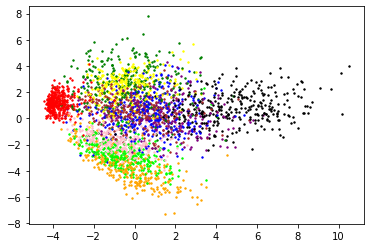

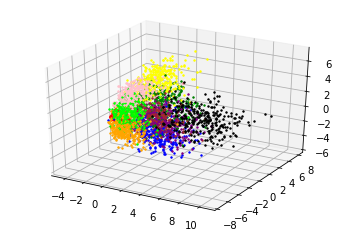

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1.]
(60000, 2)
explained variances: [0.28436944 0.20413613 0.18802621]


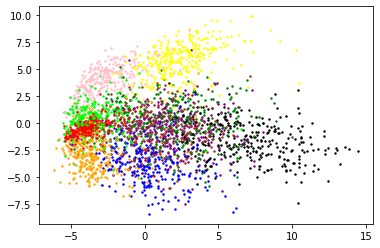

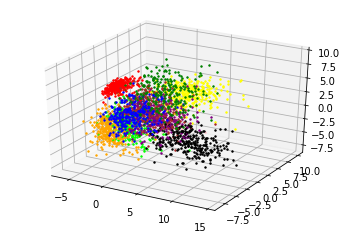

[-7.1837273  -3.8606203  -1.4899209   1.7648549   8.237203    0.46432373
 -2.042967   -1.5443436   2.2329981   4.4510775 ]
(60000, 2)
explained variances: [0.35533964 0.25318133 0.18896409]


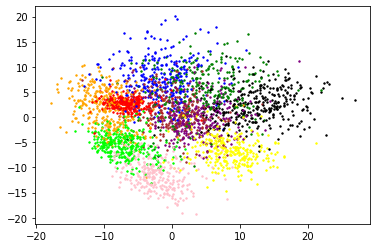

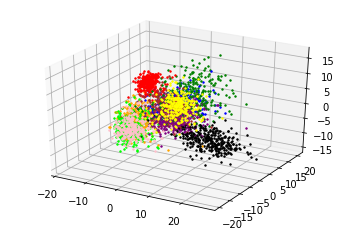

In [108]:
print("printing layer 1 PCA for train data")
analyze_activations(model.logger1, model, train_loader)
model.logger1.log = []
model.logger2.log = []
model.logger3.log = []
print("printing layer 2 PCA for train data")
analyze_activations(model.logger2, model, train_loader)
model.logger1.log = []
model.logger2.log = []
model.logger3.log = []
print("printing layer 3 PCA for train data")
analyze_activations(model.logger3, model, train_loader)

[1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.]
(10000, 2)
explained variances: [0.2044808  0.17785952 0.14575412]


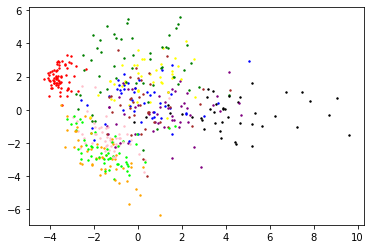

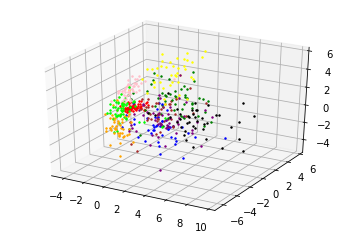

[1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1.]
(10000, 2)
explained variances: [0.28824995 0.20567931 0.1840701 ]


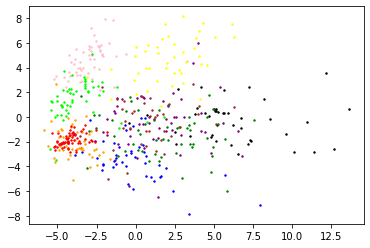

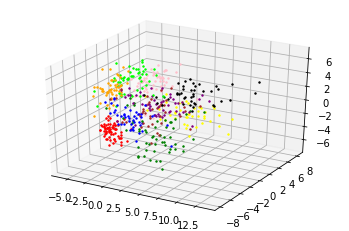

[-0.52988195 -0.80915177  4.1203513   3.8364778  -4.801299    0.19145867
 -6.6633787   8.99049    -0.54712594  0.4126583 ]
(10000, 2)
explained variances: [0.35837265 0.25864471 0.18136664]


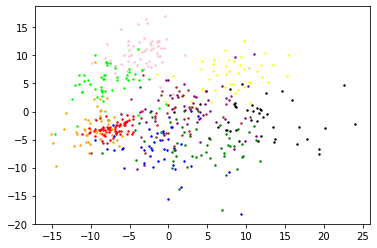

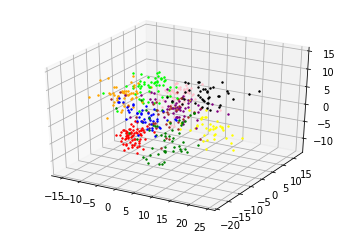

In [109]:

model.logger1.log = []
model.logger2.log = []
model.logger3.log = []
print("printing layer 1 PCA for test data")
analyze_activations(model.logger1, model, test_loader)
model.logger1.log = []
model.logger2.log = []
model.logger3.log = []
print("printing layer 2 PCA for test data")
analyze_activations(model.logger2, model, test_loader)
model.logger1.log = []
model.logger2.log = []
model.logger3.log = []
print("printing layer 3 PCA for test data")
analyze_activations(model.logger3, model, test_loader)